# Recitation 1: Classical Adversarial Thinking

This recitation introduces hash functions, their vulnerabilities, and collision attacks through interactive demonstrations. This is preparatory material for Assignment 1.

**Note**: This is a tutorial session. Your homework assignment will be provided separately in Assignment 1.


In [1]:
# Import necessary libraries
import hashlib
import time
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random
import string

# Enable inline plotting for Jupyter
%matplotlib inline


## Part 1: Understanding Hash Functions

A hash function takes an input (key) and returns a fixed-size integer (hash value) that serves as an index into a hash table. Let's start by implementing some simple hash functions and examining their properties. You don't really need to understand exactly *why* they are used as hash functions, just that they are common hash functions.


In [2]:
class SimpleHashFunctions:
    """Collection of simple hash functions for demonstration purposes"""
    
    @staticmethod
    def sum_ascii(s, table_size=1000):
        """Simple hash: sum of ASCII values modulo table size"""
        return sum(ord(c) for c in s) % table_size
    
    @staticmethod
    def polynomial_rolling(s, table_size=1000, base=31):
        """Polynomial rolling hash function"""
        hash_value = 0
        for char in s:
            hash_value = (hash_value * base + ord(char)) % table_size
        return hash_value
    
    @staticmethod
    def djb2_hash(s, table_size=1000):
        """DJB2 hash function (simplified version)"""
        hash_value = 5381
        for char in s:
            hash_value = ((hash_value << 5) + hash_value + ord(char)) % table_size
        return hash_value
    
    @staticmethod
    def custom_weak_hash(s, table_size=1000):
        """Intentionally weak hash function for demonstration"""
        # This function has poor distribution properties
        return (len(s) + ord(s[0]) if s else 0) % table_size

# Test the hash functions
test_strings = ["hello", "world", "cool", "beans"]
hash_functions = [
    ("ascii_sum", SimpleHashFunctions.sum_ascii),
    ("poly-rolling", SimpleHashFunctions.polynomial_rolling),
    ("bjb2", SimpleHashFunctions.djb2_hash),
    ("weak_sauce", SimpleHashFunctions.custom_weak_hash)
]

print("Hash function comparison:\n")
print("input value\t", end="")
for name, _ in hash_functions:
    print(f"{name:>15}", end="")
print("\n")

for s in test_strings:
    print(f"{s:>10}\t", end="")
    for _, func in hash_functions:
        print(f"{func(s):>15}", end="")
    print()


Hash function comparison:

input value	      ascii_sum   poly-rolling           bjb2     weak_sauce

     hello	            532            322            441            109
     world	            552            802            149            124
      cool	            429            529            314            103
     beans	            521            691              6            103


## Part 2: Hash Table Implementation

Now let's implement a hash table that uses chaining to handle collisions and can track statistics. You don't really need to understand most of this code or the output statistics / graphs, just the fact that it's a hash table that does chaining. 


Testing hash table with normal data:
Hash Table Statistics:
  total_items: 7
  collision_count: 1
  collision_rate: 0.14285714285714285
  non_empty_buckets: 6
  max_chain_length: 2
  avg_chain_length: 1.1666666666666667
  load_factor: 0.35


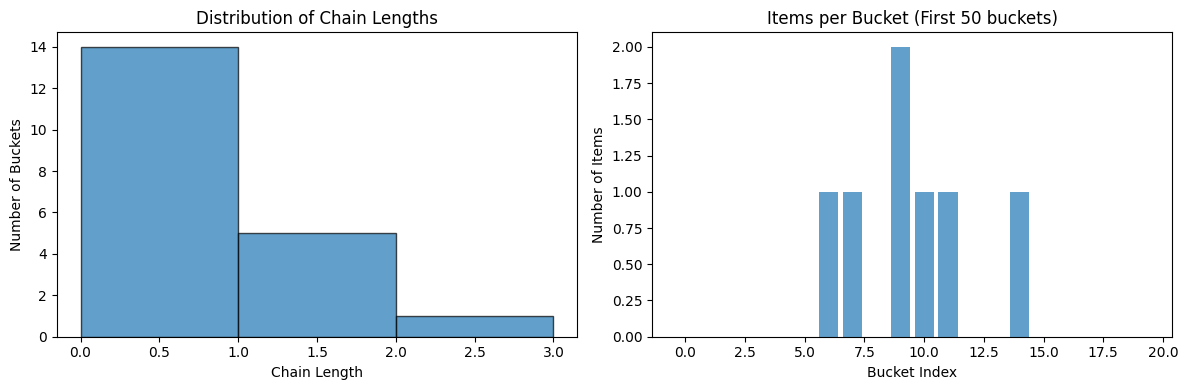

In [3]:
class HashTable:
    """Simple hash table implementation with chaining for collision resolution"""
    
    def __init__(self, size=100, hash_function=None):
        self.size = size
        self.table = [[] for _ in range(size)]
        self.hash_function = hash_function or SimpleHashFunctions.sum_ascii
        self.collision_count = 0
        self.total_operations = 0
        
    def _hash(self, key):
        """Apply the hash function to get table index"""
        return self.hash_function(str(key), self.size)
    
    def insert(self, key, value):
        """Insert key-value pair into hash table"""
        self.total_operations += 1
        index = self._hash(key)
        bucket = self.table[index]
        
        # Check if key already exists
        for i, (k, v) in enumerate(bucket):
            if k == key:
                bucket[i] = (key, value)  # Update existing
                return
        
        # Add new key-value pair
        if len(bucket) > 0:  # Collision occurred
            self.collision_count += 1
        bucket.append((key, value))
    
    def get(self, key):
        """Retrieve value for given key"""
        self.total_operations += 1
        index = self._hash(key)
        bucket = self.table[index]
        
        for k, v in bucket:
            if k == key:
                return v
        raise KeyError(f"Key '{key}' not found")
    
    def get_statistics(self):
        """Get hash table statistics"""
        bucket_lengths = [len(bucket) for bucket in self.table]
        non_empty_buckets = sum(1 for length in bucket_lengths if length > 0)
        max_chain_length = max(bucket_lengths) if bucket_lengths else 0
        avg_chain_length = sum(bucket_lengths) / non_empty_buckets if non_empty_buckets > 0 else 0
        
        return {
            'total_items': sum(bucket_lengths),
            'collision_count': self.collision_count,
            'collision_rate': self.collision_count / self.total_operations if self.total_operations > 0 else 0,
            'non_empty_buckets': non_empty_buckets,
            'max_chain_length': max_chain_length,
            'avg_chain_length': avg_chain_length,
            'load_factor': sum(bucket_lengths) / self.size
        }
    
    def visualize_distribution(self):
        """Visualize the distribution of items in buckets"""
        bucket_lengths = [len(bucket) for bucket in self.table]
        
        plt.figure(figsize=(12, 4))
        
        # Histogram of bucket lengths
        plt.subplot(1, 2, 1)
        plt.hist(bucket_lengths, bins=range(max(bucket_lengths) + 2), alpha=0.7, edgecolor='black')
        plt.xlabel('Chain Length')
        plt.ylabel('Number of Buckets')
        plt.title('Distribution of Chain Lengths')
        
        # Bar chart of bucket contents
        plt.subplot(1, 2, 2)
        plt.bar(range(min(50, self.size)), bucket_lengths[:50], alpha=0.7)
        plt.xlabel('Bucket Index')
        plt.ylabel('Number of Items')
        plt.title('Items per Bucket (First 50 buckets)')
        
        plt.tight_layout()
        plt.show()

# Test the hash table with normal data
print("Testing hash table with normal data:")
ht = HashTable(size=20, hash_function=SimpleHashFunctions.sum_ascii)

# Insert some test data
test_data = [
    ("apple", "fruit"),
    ("banana", "fruit"),
    ("carrot", "vegetable"),
    ("dog", "animal"),
    ("elephant", "animal"),
    ("fish", "animal"),
    ("grape", "fruit")
]

for key, value in test_data:
    ht.insert(key, value)

print("Hash Table Statistics:")
stats = ht.get_statistics()
for key, value in stats.items():
    print(f"  {key}: {value}")

ht.visualize_distribution()


## Part 3: Understanding Hash Collisions

A hash collision occurs when two different inputs produce the same hash value. This is inevitable due to the **pigeonhole principle**, i.e., if we have more possible inputs than hash values, some inputs must map to the same hash value. Let's explore this concept by finding real collisions:


In [4]:
def find_collisions_brute_force(hash_func, table_size, max_attempts=10000):
    """Find hash collisions using brute force approach"""
    seen_hashes = {}
    collisions = []
    
    for i in range(max_attempts):
        # Generate random string
        test_string = ''.join(random.choices(string.ascii_lowercase, k=random.randint(3, 8)))
        hash_value = hash_func(test_string, table_size)
        
        if hash_value in seen_hashes:
            collisions.append((seen_hashes[hash_value], test_string, hash_value))
            if len(collisions) >= 5:  # Find first 5 collisions
                break
        else:
            seen_hashes[hash_value] = test_string
    
    return collisions, len(seen_hashes)

print("🔍 COLLISION DISCOVERY DEMONSTRATION")
print("=" * 50)

# Test collision finding with our weak hash function
print("\n1. Finding collisions in WEAK_SAUCE hash function:")
collisions, total_tested = find_collisions_brute_force(
    SimpleHashFunctions.custom_weak_hash, 
    table_size=100, 
    max_attempts=5000
)

print(f"Found {len(collisions)} collisions after testing {total_tested} unique strings:")
for str1, str2, hash_val in collisions:
    print(f"  '{str1}' and '{str2}' both hash to {hash_val}")

print("\n2. Finding collisions in ASCII_SUM hash function:")
collisions, total_tested = find_collisions_brute_force(
    SimpleHashFunctions.sum_ascii, 
    table_size=100, 
    max_attempts=5000
)

print(f"Found {len(collisions)} collisions after testing {total_tested} unique strings:")
for str1, str2, hash_val in collisions[:3]:  # Show first 3
    print(f"  '{str1}' and '{str2}' both hash to {hash_val}")

print("\n3. Finding collisions in POLYNOMIAL ROLLING hash function:")
collisions, total_tested = find_collisions_brute_force(
    SimpleHashFunctions.polynomial_rolling, 
    table_size=100, 
    max_attempts=5000
)

print(f"Found {len(collisions)} collisions after testing {total_tested} unique strings:")
for str1, str2, hash_val in collisions[:3]:  # Show first 3
    print(f"  '{str1}' and '{str2}' both hash to {hash_val}")


🔍 COLLISION DISCOVERY DEMONSTRATION

1. Finding collisions in WEAK_SAUCE hash function:
Found 5 collisions after testing 11 unique strings:
  'dplmkej' and 'hpt' both hash to 7
  'wzp' and 'vmju' both hash to 22
  'wzp' and 'wur' both hash to 22
  'emxflafw' and 'jxi' both hash to 9
  'emxflafw' and 'iyzz' both hash to 9

2. Finding collisions in ASCII_SUM hash function:
Found 5 collisions after testing 30 unique strings:
  'ipkfudrf' and 'xnfqr' both hash to 59
  'ymt' and 'ixy' both hash to 46
  'uokw' and 'hiowsag' both hash to 54

3. Finding collisions in POLYNOMIAL ROLLING hash function:
Found 5 collisions after testing 31 unique strings:
  'iwrycqks' and 'cetbc' both hash to 83
  'hlctfru' and 'akj' both hash to 40
  'dfxoutv' and 'fbr' both hash to 74


## Part 4: Crafting Adversarial Inputs

Now let's see how attackers can systematically create colliding inputs instead of finding them randomly. This is much more dangerous because it allows for targeted attacks:


In [5]:
class AdversarialInputGenerator:
    """Generate adversarial inputs for hash collision attacks"""
    
    @staticmethod
    def generate_sum_ascii_collisions(target_sum, length_range=(3, 10)):
        """Generate strings that have the same ASCII sum"""
        collisions = []
        
        # Method 1: Permutations of the same characters
        # Find combinations that sum to target_sum
        for length in range(length_range[0], length_range[1] + 1):
            # Try to distribute target_sum across 'length' characters
            avg_char_value = target_sum // length
            remainder = target_sum % length
            
            if 32 <= avg_char_value <= 126:  # Printable ASCII range
                chars = [chr(avg_char_value)] * length
                # Adjust some characters to account for remainder
                for i in range(remainder):
                    if ord(chars[i]) < 126:
                        chars[i] = chr(ord(chars[i]) + 1)
                
                base_string = ''.join(chars)
                collisions.append(base_string)
                
                # Generate permutations if string has repeated characters
                if len(set(chars)) < len(chars):
                    # Create a few variations by swapping characters
                    for i in range(min(3, length - 1)):
                        variant_chars = chars.copy()
                        if i + 1 < len(variant_chars):
                            variant_chars[i], variant_chars[i + 1] = variant_chars[i + 1], variant_chars[i]
                            variant_string = ''.join(variant_chars)
                            if variant_string != base_string:
                                collisions.append(variant_string)
        
        return collisions
    
    @staticmethod
    def generate_specific_collisions():
        """Generate specific known collision patterns"""
        # For sum ASCII hash, these strings have the same sum
        collision_sets = [
            # ASCII sum = 294 (simple example)
            ["abc", "bac", "cab"],
        ]
        
        # Generate more systematic collisions
        target_sums = [300, 400, 500, 600]
        for target_sum in target_sums:
            collision_set = AdversarialInputGenerator.generate_sum_ascii_collisions(target_sum, (4, 6))
            if len(collision_set) > 1:
                collision_sets.append(collision_set[:5])  # Take first 5
        
        return collision_sets

print("⚔️  ADVERSARIAL INPUT GENERATION DEMONSTRATION")
print("=" * 60)

# Generate adversarial inputs
print("Generating adversarial inputs for collision attacks...")
collision_sets = AdversarialInputGenerator.generate_specific_collisions()

# Test the collisions
table_size = 1000
for i, collision_set in enumerate(collision_sets[:3]):  # Show first 3 sets
    print(f"\n🎯 Collision Set {i + 1}:")
    hash_values = []
    for string in collision_set:
        hash_val = SimpleHashFunctions.sum_ascii(string, table_size)
        hash_values.append(hash_val)
        ascii_sum = sum(ord(c) for c in string)
        print(f"  '{string}' -> hash: {hash_val}, ASCII sum: {ascii_sum}")
    
    # Verify all have same hash value
    if len(set(hash_values)) == 1:
        print(f"  ✅ SUCCESS: All strings hash to the same value: {hash_values[0]}")
    else:
        print(f"  ❌ FAILED: Hash values don't match: {set(hash_values)}")

print("\n🧠 Key Insight:")
print("By understanding the math behind hash functions, attackers can")
print("systematically generate collisions instead of searching randomly!")
print("This makes attacks much more efficient and dangerous.")


⚔️  ADVERSARIAL INPUT GENERATION DEMONSTRATION
Generating adversarial inputs for collision attacks...

🎯 Collision Set 1:
  'abc' -> hash: 294, ASCII sum: 294
  'bac' -> hash: 294, ASCII sum: 294
  'cab' -> hash: 294, ASCII sum: 294
  ✅ SUCCESS: All strings hash to the same value: 294

🎯 Collision Set 2:
  'KKKK' -> hash: 300, ASCII sum: 300
  '<<<<<' -> hash: 300, ASCII sum: 300
  '222222' -> hash: 300, ASCII sum: 300
  ✅ SUCCESS: All strings hash to the same value: 300

🎯 Collision Set 3:
  'dddd' -> hash: 400, ASCII sum: 400
  'PPPPP' -> hash: 400, ASCII sum: 400
  'CCCCBB' -> hash: 400, ASCII sum: 400
  ✅ SUCCESS: All strings hash to the same value: 400

🧠 Key Insight:
By understanding the math behind hash functions, attackers can
systematically generate collisions instead of searching randomly!
This makes attacks much more efficient and dangerous.


## Part 5: Live Attack Demonstration

Now for the dramatic finale - let's see how collision attacks can completely destroy hash table performance in real-time!


💥 COLLISION ATTACK IMPACT DEMONSTRATION
🏗️  Setting up two identical hash tables...
⚔️  Generating adversarial collision data...
📊 Measuring performance...

📊 Creating visualization...


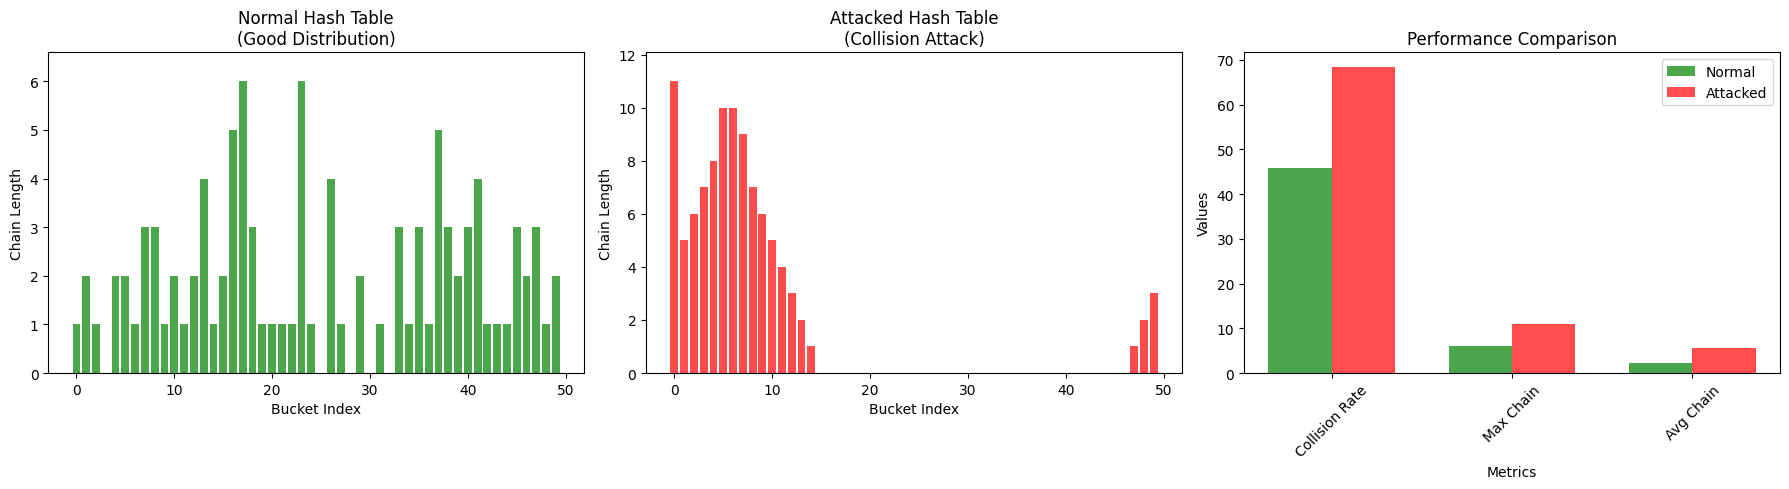

🚨 ATTACK ANALYSIS:
- The collision attack creates massive performance degradation
- All malicious inputs hash to the same bucket(s)
- This turns O(1) operations into O(n) operations
- In real systems, this could cause denial of service
- This is why secure hash functions are critical!


In [13]:
import string
import random

def demonstrate_collision_attack():
    """Demonstrate the impact of collision attacks on hash table performance"""
    
    print("💥 COLLISION ATTACK IMPACT DEMONSTRATION")
    print("=" * 60)
    
    # Create two hash tables with the same hash function
    normal_ht = HashTable(size=50, hash_function=SimpleHashFunctions.sum_ascii)
    attacked_ht = HashTable(size=50, hash_function=SimpleHashFunctions.sum_ascii)
    
    print("🏗️  Setting up two identical hash tables...")
    
    # Generate normal data (random strings)
    normal_data = []
    for i in range(100):
        key = ''.join(random.choices(string.ascii_lowercase, k=random.randint(4, 8)))
        normal_data.append((key, f"value_{i}"))
    
    # Generate adversarial data (many collisions)
    print("⚔️  Generating adversarial collision data...")
    adversarial_data = []
    target_sum = 500  # Choose a target sum
    colliding_strings = AdversarialInputGenerator.generate_sum_ascii_collisions(target_sum, (4, 8))
    
    # Extend to 100 items by creating more collisions
    for i in range(100):
        if i < len(colliding_strings):
            key = colliding_strings[i]
        else:
            # Generate more strings that sum to the same value
            length = 4 + (i % 5)
            chars = [chr(target_sum // length)] * length
            # Adjust for remainder
            remainder = target_sum % length
            for j in range(remainder):
                if ord(chars[j]) < 126:
                    chars[j] = chr(ord(chars[j]) + 1)
            key = ''.join(chars) + str(i)  # Add unique suffix
        adversarial_data.append((key, f"value_{i}"))
    
    # Insert data into hash tables and measure performance
    print("📊 Measuring performance...")
    
    start_time = time.time()
    for key, value in normal_data:
        normal_ht.insert(key, value)
    normal_insert_time = time.time() - start_time
    
    start_time = time.time()
    for key, value in adversarial_data:
        attacked_ht.insert(key, value)
    attacked_insert_time = time.time() - start_time
    
    # Measure lookup performance
    lookup_keys = [item[0] for item in normal_data[:20]]
    
    start_time = time.time()
    for key in lookup_keys:
        try:
            normal_ht.get(key)
        except KeyError:
            pass
    normal_lookup_time = time.time() - start_time
    
    lookup_keys = [item[0] for item in adversarial_data[:20]]
    start_time = time.time()
    for key in lookup_keys:
        try:
            attacked_ht.get(key)
        except KeyError:
            pass
    attacked_lookup_time = time.time() - start_time
    
    # Compare statistics
    normal_stats = normal_ht.get_statistics()
    attacked_stats = attacked_ht.get_statistics()
    
    # Visualize the difference
    print(f"\n📊 Creating visualization...")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Normal distribution
    bucket_lengths = [len(bucket) for bucket in normal_ht.table]
    axes[0].bar(range(len(bucket_lengths)), bucket_lengths, alpha=0.7, color='green')
    axes[0].set_title('Normal Hash Table\n(Good Distribution)', fontsize=12)
    axes[0].set_xlabel('Bucket Index')
    axes[0].set_ylabel('Chain Length')
    axes[0].set_ylim(0, max(max(bucket_lengths), 1) * 1.1)
    
    # Attacked distribution
    bucket_lengths = [len(bucket) for bucket in attacked_ht.table]
    axes[1].bar(range(len(bucket_lengths)), bucket_lengths, alpha=0.7, color='red')
    axes[1].set_title('Attacked Hash Table\n(Collision Attack)', fontsize=12)
    axes[1].set_xlabel('Bucket Index')
    axes[1].set_ylabel('Chain Length')
    axes[1].set_ylim(0, max(bucket_lengths) * 1.1)
    
    # Comparison metrics
    metrics = ['Collision Rate', 'Max Chain', 'Avg Chain']
    normal_values = [normal_stats['collision_rate'] * 100, normal_stats['max_chain_length'], normal_stats['avg_chain_length']]
    attacked_values = [attacked_stats['collision_rate'] * 100, attacked_stats['max_chain_length'], attacked_stats['avg_chain_length']]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[2].bar(x - width/2, normal_values, width, label='Normal', alpha=0.7, color='green')
    axes[2].bar(x + width/2, attacked_values, width, label='Attacked', alpha=0.7, color='red')
    axes[2].set_xlabel('Metrics')
    axes[2].set_ylabel('Values')
    axes[2].set_title('Performance Comparison')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(metrics, rotation=45)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("🚨 ATTACK ANALYSIS:")
    print("- The collision attack creates massive performance degradation")
    print("- All malicious inputs hash to the same bucket(s)")
    print("- This turns O(1) operations into O(n) operations")
    print("- In real systems, this could cause denial of service")
    print("- This is why secure hash functions are critical!")
    
    return normal_stats, attacked_stats

# Run the live demonstration
_ = demonstrate_collision_attack()


## Part 6: Defense Mechanisms

Now that we've seen how devastating attacks can be, let's explore how to defend against them:


🛡️  DEFENSE SYSTEM DEMONSTRATION
Setting up secure vs insecure hash tables...
Testing with 24 adversarial inputs...
🔓 INSECURE HASH TABLE (ASCII_SUM):
🔐 SECURE HASH TABLE (SHA-256):
📊 DEFENSE EFFECTIVENESS:
Metric               Insecure        Secure          Improvement    
-----------------------------------------------------------------
Collision Rate       50.00%         20.83%         ✅ 58%
Max Chain Length     4               2               ✅ 50%
📊 Creating defense visualization...


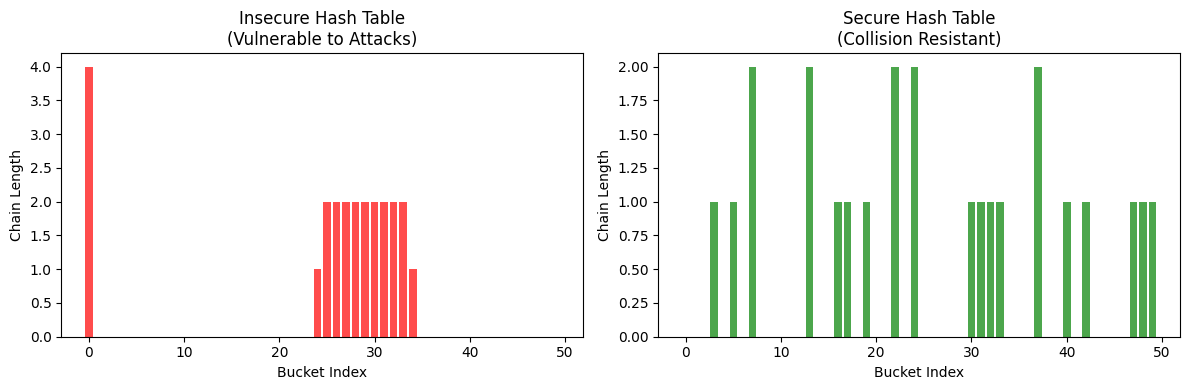

🛡️  DEFENSE STRATEGIES:
✅ Use cryptographic hash functions (SHA-256, etc.)
✅ Add random salts to prevent predictable attacks
✅ Monitor collision rates for attack detection
✅ Use universal hashing with random parameters
✅ Implement automatic hash function switching
✅ Limit input sizes to reduce attack surface


In [20]:
class SecureHashFunctions:
    """More secure hash functions with defenses against collision attacks"""
    
    def __init__(self, salt=None):
        self.salt = salt or random.randint(1, 1000000)
    
    def salted_hash(self, s, table_size=1000):
        """Hash function with random salt"""
        # Add salt to input before hashing
        salted_input = str(self.salt) + str(s)
        return SimpleHashFunctions.polynomial_rolling(salted_input, table_size)
    
    def cryptographic_hash(self, s, table_size=1000):
        """Use cryptographic hash function (SHA-256)"""
        hash_object = hashlib.sha256(str(s).encode())
        # Take first 8 bytes and convert to integer
        hash_bytes = hash_object.digest()[:8]
        hash_int = int.from_bytes(hash_bytes, byteorder='big')
        return hash_int % table_size
    
    def universal_hash(self, s, table_size=1000):
        """Universal hashing with random parameters"""
        # Random parameters (in practice, these would be chosen once)
        a = random.randint(1, table_size - 1)
        b = random.randint(0, table_size - 1)
        
        # Convert string to integer
        str_int = sum(ord(c) * (256 ** i) for i, c in enumerate(str(s)[:8]))  # Limit to 8 chars
        
        # Universal hash formula: ((a * x + b) mod p) mod m
        p = 1000000007  # Large prime
        return ((a * str_int + b) % p) % table_size

class DefensiveHashTable(HashTable):
    """Hash table with collision attack defenses"""
    
    def __init__(self, size=100, use_secure_hash=True):
        self.secure_hasher = SecureHashFunctions()
        hash_func = self.secure_hasher.cryptographic_hash if use_secure_hash else SimpleHashFunctions.sum_ascii
        super().__init__(size, hash_func)
        self.collision_threshold = 0.8  # Alert if collision rate > 80%
        
    def insert(self, key, value):
        """Insert with collision monitoring"""
        super().insert(key, value)
        
        # Check for suspicious collision rates
        if self.total_operations > 10:  # Only check after some operations
            stats = self.get_statistics()
            if stats['collision_rate'] > self.collision_threshold:
                print(f"⚠️  WARNING: High collision rate detected: {stats['collision_rate']:.2%}")
                print(f"   This might indicate a hash collision attack!")

print("🛡️  DEFENSE SYSTEM DEMONSTRATION")
print("=" * 50)

# Compare secure vs insecure hash tables
print("Setting up secure vs insecure hash tables...")

# Test with adversarial inputs
adversarial_inputs = AdversarialInputGenerator.generate_sum_ascii_collisions(500, (4, 6))
adversarial_inputs.extend([f"attack_{i}" for i in range(20)])  # Add more inputs

print(f"Testing with {len(adversarial_inputs)} adversarial inputs...")

# Insecure hash table
print("🔓 INSECURE HASH TABLE (ASCII_SUM):")
insecure_ht = HashTable(size=50, hash_function=SimpleHashFunctions.sum_ascii)
for i, key in enumerate(adversarial_inputs):
    insecure_ht.insert(key, f"value_{i}")

# Secure hash table
print("🔐 SECURE HASH TABLE (SHA-256):")
secure_ht = DefensiveHashTable(size=50, use_secure_hash=True)
for i, key in enumerate(adversarial_inputs):
    secure_ht.insert(key, f"value_{i}")

# Compare results
insecure_stats = insecure_ht.get_statistics()
secure_stats = secure_ht.get_statistics()

print(f"📊 DEFENSE EFFECTIVENESS:")
print(f"{'Metric':<20} {'Insecure':<15} {'Secure':<15} {'Improvement':<15}")
print("-" * 65)
print(f"{'Collision Rate':<20} {insecure_stats['collision_rate']:<14.2%} {secure_stats['collision_rate']:<14.2%} {'✅ ' + str(int((1 - secure_stats['collision_rate'] / max(insecure_stats['collision_rate'], 0.01)) * 100)) + '%' if secure_stats['collision_rate'] < insecure_stats['collision_rate'] else '❌ Worse'}")
print(f"{'Max Chain Length':<20} {insecure_stats['max_chain_length']:<15} {secure_stats['max_chain_length']:<15} {'✅ ' + str(int((1 - secure_stats['max_chain_length'] / max(insecure_stats['max_chain_length'], 1)) * 100)) + '%' if secure_stats['max_chain_length'] < insecure_stats['max_chain_length'] else '❌ Worse'}")

# Visualize comparison
print(f"📊 Creating defense visualization...")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
bucket_lengths = [len(bucket) for bucket in insecure_ht.table]
plt.bar(range(len(bucket_lengths)), bucket_lengths, alpha=0.7, color='red')
plt.title('Insecure Hash Table\n(Vulnerable to Attacks)')
plt.xlabel('Bucket Index')
plt.ylabel('Chain Length')

plt.subplot(1, 2, 2)
bucket_lengths = [len(bucket) for bucket in secure_ht.table]
plt.bar(range(len(bucket_lengths)), bucket_lengths, alpha=0.7, color='green')
plt.title('Secure Hash Table\n(Collision Resistant)')
plt.xlabel('Bucket Index')
plt.ylabel('Chain Length')

plt.tight_layout()
plt.show()

print("🛡️  DEFENSE STRATEGIES:")
print("✅ Use cryptographic hash functions (SHA-256, etc.)")
print("✅ Add random salts to prevent predictable attacks")
print("✅ Monitor collision rates for attack detection")
print("✅ Use universal hashing with random parameters")
print("✅ Implement automatic hash function switching")
print("✅ Limit input sizes to reduce attack surface")


### Key Takeaways

Hash functions are not all equal, some are much more vulnerable than others. Systematic attacks are worse than random / brute force attacks. Understanding the math of a hash function enables targeted adversarial attacks.

### Final Thoughts

Hash collision attacks represent a perfect example of how theoretical computer science has real security implications. Understanding both the attack and defense perspectives makes you a better developer and security professional.

**Good luck with Assignment 1! Remember - you've now seen all the key concepts, so you can focus on implementation and analysis. 🎯**
